Welcome to the 5th part of the NLP concepts series. In this notebook, we will cover attention mechanism and transformers.

Before starting here are two nice resources for you to understand the concepts:

* [Transformers - RASA](https://www.youtube.com/watch?v=yGTUuEx3GkA&t=2s)
* [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

# Attention

## Self-Attention

In sequential data analysis, in order to eliminate the noise, we use several types of methods. These methods often involve weighing and averaging the data points.

* Simple and exponential moving averages

In NLP, we know that the meaning of a word depends on the words near by i.e. context but we can not assign the importance only by looking the distance between points. Sometimes for example a word in the beginning has the greatest impact on a word located at the end of the sentence. We need to mitigate this issue somehow.

The simplest way to weighing a word $i$ with respect to word $j$ is getting dot product. We know that similar words have similar embeddings so this should work:

&
$W_{ij} = <V_i,V_j>$

and the output

$y_i = \sum_j W_{ij}V_j$

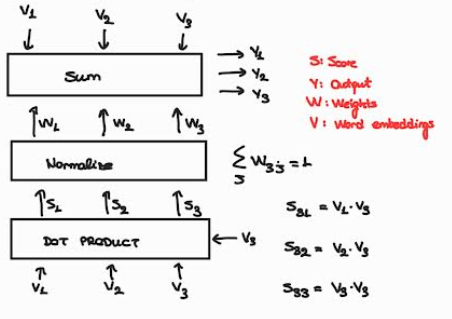

The baseline model has couple down sides:
* This method does not consider the order of the words.
* The weights are not trainable. They are just dot product of two words.
* The output is shape independent.


That's when Query, Key and Value Matricies come into play. We will rebuild the same configuration, but this time we will add three trainable matricies:

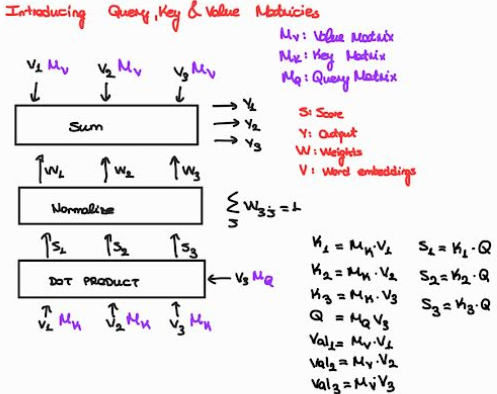


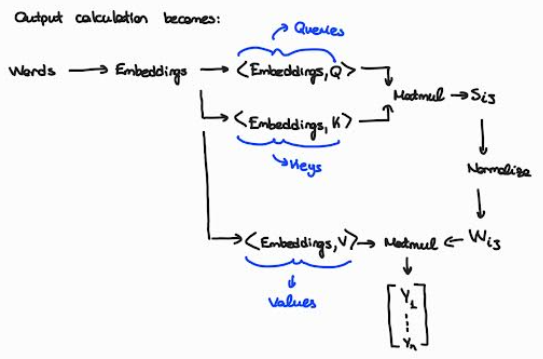



The final model is called *self-attention*.


## Multi-head Attention

If we build the same model using multiple Key, Query and Value Matrices, we get a Multi-head Attention layer. By creating multiple heads, we are attempting to distribute the workload through the heads so we improve the models' attention ability.

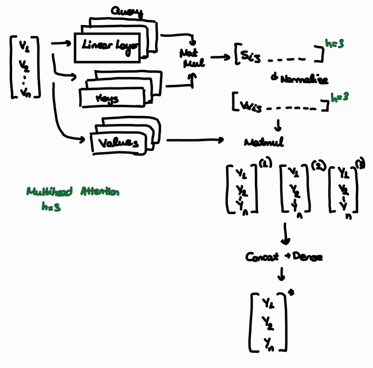

# Transformers

Transformers are the state-of-art models  in the NLP era for various tasks currently. They are successful and parallelizable. They include the following parts:
1. **Encoder:** The task of an encoder is to abstract (understand the context) the input text.
2. **Decoder:** The task of a decoder is to get these abstractions and generate new a new text (translation for instance).

For specific NLP tasks, one might prioritize one component over the other.  In these kind of situations, it is feasible to use one part solely. For example BERT, is an encoder only model. The abstractions of the BERT can be used for various tasks (I'll provide some examples later in the notebook).

A transformer model looks like this:

(source: Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.)

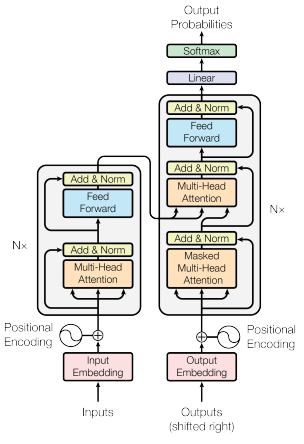

A couple of important points to consider:

1. Instead of directly feeding to the model, word embeddings are combined with the positional vectors. Positional vectors indicate the position of a word which helps the model also to include the relative order in the learning process.

2. There are several residual units in an encoder block. This makes the model resistant to Vanishing Gradient Problem (same logic with the ResNet)

3. Encoder - Decoder Attention Layer is similar to the Multi-head attention layer. The only difference is that this layer only creates its own Query matrix and takes Key & Value matrices from the encoder.

## BERT

In this section, I will show how to use BERT for different purposes.

### BERT for Text Classification

In [1]:
#import the libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_datasets as tfds

!pip install tensorflow_text
import tensorflow_text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#get the datasets
train_dataset,test_dataset = tfds.load('ag_news_subset', split = ['train','test'],
                                       as_supervised=True,
                                       shuffle_files = True,
                                       batch_size = 32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompletePDC8F2/ag_news_subset-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompletePDC8F2/ag_news_subset-test.tfrecord*...:   …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [3]:
for text,label in train_dataset.unbatch().take(1):
  print('Text:', text.numpy())
  print('Label',label.numpy())

Text: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
Label 3


In [4]:
#prepare bert
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

#build  the model
inputs = layers.Input(shape = (), dtype = tf.string)# shape = () means the sequences have variable length
x = preprocessor(inputs,training = False)
x = encoder_model(x,training = False)
x = x['pooled_output']
outputs = tf.keras.layers.Dense(4,activation = 'softmax')(x)

bert_model = tf.keras.models.Model(inputs,outputs)

#compile the model
bert_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

#fit the model
history = bert_model.fit(train_dataset,
               validation_data = test_dataset,
               epochs = 1)

3750/3750 [==============================] - 1312s 347ms/step - loss: 0.6387 - accuracy: 0.7775 - val_loss: 0.4808 - val_accuracy: 0.8328


In [5]:
del bert_model

!pip install numba 
from numba import cuda 
device = cuda.get_current_device()
device.reset()

## BERT for Sentiment Analysis

There are several kinds of BERT models. RoBERTa is one of them. The researchers found that BERT is significantly undertrained therefore they decided to train it for longer. Here are all the modifications they did:

(source: Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., ... & Stoyanov, V. (2019). Roberta: A robustly optimized bert pretraining approach. arXiv preprint arXiv:1907.11692.)

>Our modifications are simple, they include: (1) training the model longer, with bigger batches, over more data; (2) removing the next sentence prediction objective; (3) training on longer sequences; and (4) dynamically changing the masking pattern applied to the training data. We also collect a large new dataset (CC-NEWS) of comparable size to other privately used datasets, to better
control for training set size effects.

We will use RoBERTa for both sentiment & emotion analysis.


In [6]:
!pip install transformers
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

import numpy as np
from scipy.special import softmax
import csv
import pandas as pd

from tqdm import tqdm
tqdm.pandas()
import urllib.request

In [7]:
#get the model & tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#transport it into GPU
model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [8]:
#get labels
labels=[]
task = 'sentiment'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
print(labels)

#define the suggested preprocessing function
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

['negative', 'neutral', 'positive']


In [9]:
#read the dataset
df = pd.read_csv('/kaggle/input/emotion-dataset/Emotion_classify_Data.csv')
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [10]:
#comment scoring function
def label_comments(row):
  preprocessed_text = preprocess(row['Comment'])
  encoded_input = tokenizer(preprocessed_text,return_tensors = 'pt').to('cuda')
  output = model(**encoded_input)
  scores = softmax(output.logits.cpu().detach().numpy()[0])
  return scores

#comment labeling function
def label_scores(row):
  cols = df.columns[2:]
  max_idx = np.argmax(row[2:])
  return cols[max_idx]

In [11]:
#generate score and label columns
df[['negative','neutral','positive']] = df.progress_apply(lambda x: label_comments(x),axis = 1,result_type = 'expand')
df['prediction_labels'] = df.progress_apply(label_scores,axis = 1)

100%|██████████| 5937/5937 [00:00<00:00, 9834.03it/s]


In [12]:
df.head(10)

,Comment,Emotion,negative,neutral,positive,prediction_labels
0,i seriously hate one subject to death but now ...,fear,0.968618,0.027370,0.004011,negative
1,im so full of life i feel appalled,anger,0.586002,0.295312,0.118686,negative
2,i sit here to write i start to dig out my feel...,fear,0.704056,0.278971,0.016973,negative
3,ive been really angry with r and i feel like a...,joy,0.979444,0.018869,0.001687,negative
4,i feel suspicious if there is no one outside l...,fear,0.667410,0.322095,0.010496,negative
5,i feel jealous becasue i wanted that kind of l...,anger,0.387653,0.457108,0.155239,neutral
6,when a friend of mine keeps telling me morbid ...,anger,0.740536,0.250167,0.009296,negative
7,i finally fell asleep feeling angry useless an...,anger,0.910095,0.079880,0.010025,negative
8,i feel a bit annoyed and antsy in a good way,anger,0.876885,0.106313,0.016802,negative
9,i feel like i ve regained another vital part o...,joy,0.003316,0.114142,0.882542,positive


In [13]:
del model
device = cuda.get_current_device()
device.reset()

## BERT for Emotion Analysis

In [14]:
!pip install transformers
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

import numpy as np
from scipy.special import softmax
import csv
import pandas as pd

from tqdm import tqdm
tqdm.pandas()
import urllib.request

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
model_name = "cardiffnlp/twitter-roberta-base-emotion"

#get tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [16]:
#get labels
labels=[]
task = 'emotion'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
print(labels)

#define the suggested preprocessing function
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

['anger', 'joy', 'optimism', 'sadness']


In [17]:
#comment scoring function
def label_comments(row):
  preprocessed_comment = preprocess(row['Comment'])
  tokens = tokenizer(preprocessed_comment,return_tensors = 'pt')
  outputs = model(**tokens)
  scores = softmax(outputs.logits.cpu().detach().numpy()[0])
  return scores

#comment labeling function
def label_scores(row):
  cols = df.columns[2:]
  max_idx = np.argmax(row[2:])
  return cols[max_idx]

In [18]:
#read the dataset
df = pd.read_csv('/kaggle/input/emotion-dataset/Emotion_classify_Data.csv')
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [19]:
#generate score and label columns
df[['anger', 'joy', 'optimism', 'sadness']] = df.progress_apply(label_comments, axis = 1, result_type = 'expand')
df['labels'] = df.progress_apply(label_scores,axis = 1)
df.head()

100%|██████████| 5937/5937 [00:00<00:00, 9942.26it/s] 


,Comment,Emotion,anger,joy,optimism,sadness,labels
0,i seriously hate one subject to death but now ...,fear,0.440179,0.010862,0.013821,0.535138,sadness
1,im so full of life i feel appalled,anger,0.518671,0.040349,0.028191,0.412788,anger
2,i sit here to write i start to dig out my feel...,fear,0.010740,0.005708,0.017786,0.965767,sadness
3,ive been really angry with r and i feel like a...,joy,0.977480,0.005059,0.008988,0.008474,anger
4,i feel suspicious if there is no one outside l...,fear,0.131727,0.023179,0.035961,0.809133,sadness
